In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
# from tools.GRU_SingleStep_v11 import RNN_GRU
from tools.LSTM_SingleStep_v1 import RNN_LSTM as RNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-01-11 17:07:05.485190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-11 17:07:05.485457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:07:05.529464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:07:05.529747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:07:05.530119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 17:07:05.530389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

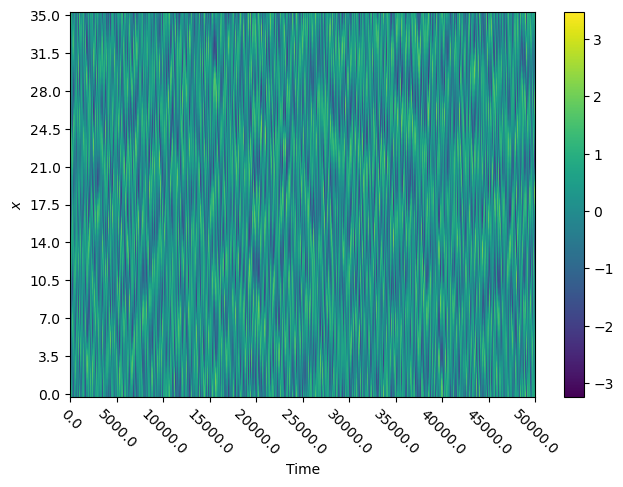

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

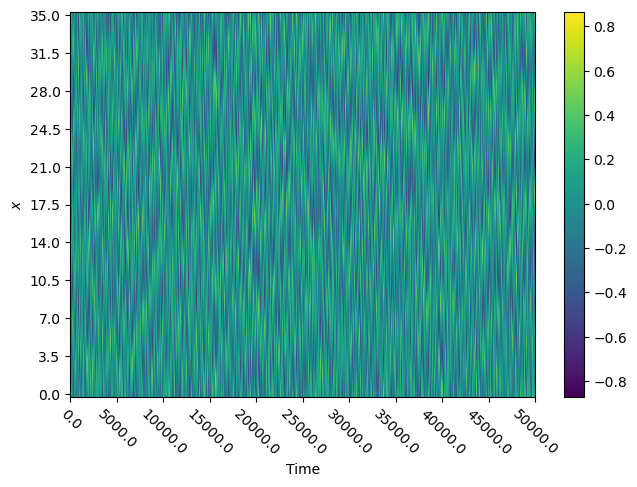

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

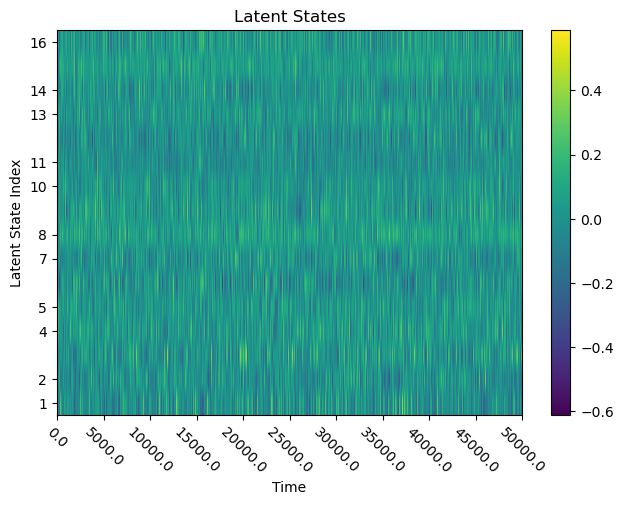

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# RNN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [500]*3
    scalar_weights = [1.0, 0.5, 0.5]
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
            )
    else:
        rnn_net = RNN(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_rnn_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.006613247394561768


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0444 - mse: 0.0430 - NMSE: 0.3868 - tot_time: 0h 0m 20.6s

Epoch 1: val_NMSE improved from inf to 0.15129, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 21s 2s/step - loss: 0.0444 - mse: 0.0430 - NMSE: 0.3868 - val_loss: 0.0182 - val_mse: 0.0168 - val_NMSE: 0.1513
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0113 - NMSE: 0.1014 - tot_time: 0h 0m 37.6s

Epoch 2: val_NMSE improved from 0.15129 to 0.07705, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0011 - NMSE: 0.0101 - tot_time: 0h 4m 22.3s

Epoch 15: val_NMSE improved from 0.01842 to 0.01790, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0024 - mse: 0.0011 - NMSE: 0.0101 - val_loss: 0.0033 - val_mse: 0.0020 - val_NMSE: 0.0179
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0011 - NMSE: 0.0097 - tot_time: 0h 4m 39.6s

Epoch 16: val_NMSE improved from 0.01790 to 0.01744, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - lo

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 6.9697e-04 - NMSE: 0.0063 - tot_time: 0h 8m 40.8s

Epoch 30: val_NMSE improved from 0.01342 to 0.01319, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0018 - mse: 6.9697e-04 - NMSE: 0.0063 - val_loss: 0.0026 - val_mse: 0.0015 - val_NMSE: 0.0132
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 6.7929e-04 - NMSE: 0.0061 - tot_time: 0h 8m 58.0s

Epoch 31: val_NMSE improved from 0.01319 to 0.01298, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [========================

Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 5.1105e-04 - NMSE: 0.0046 - tot_time: 0h 12m 58.7s

Epoch 45: val_NMSE improved from 0.01084 to 0.01074, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0015 - mse: 5.1105e-04 - NMSE: 0.0046 - val_loss: 0.0021 - val_mse: 0.0012 - val_NMSE: 0.0107
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 0.0014 - mse: 5.0155e-04 - NMSE: 0.0045 - tot_time: 0h 13m 16.0s

Epoch 46: val_NMSE improved from 0.01074 to 0.01060, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [======================

Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 3.8346e-04 - NMSE: 0.0035 - tot_time: 0h 17m 17.0s

Epoch 60: val_NMSE improved from 0.00905 to 0.00899, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0012 - mse: 3.8346e-04 - NMSE: 0.0035 - val_loss: 0.0018 - val_mse: 9.9830e-04 - val_NMSE: 0.0090
Epoch 61/1000
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 3.8107e-04 - NMSE: 0.0034 - tot_time: 0h 17m 34.3s

Epoch 61: val_NMSE improved from 0.00899 to 0.00894, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==================

Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 3.1727e-04 - NMSE: 0.0029 - tot_time: 0h 21m 35.0s

Epoch 75: val_NMSE improved from 0.00793 to 0.00789, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0011 - mse: 3.1727e-04 - NMSE: 0.0029 - val_loss: 0.0017 - val_mse: 8.7630e-04 - val_NMSE: 0.0079
Epoch 76/1000
8/8 [==============================] - ETA: 0s - loss: 0.0011 - mse: 3.1429e-04 - NMSE: 0.0028 - tot_time: 0h 21m 52.4s

Epoch 76: val_NMSE improved from 0.00789 to 0.00778, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0010 - mse: 2.6427e-04 - NMSE: 0.0024 - val_loss: 0.0015 - val_mse: 7.7835e-04 - val_NMSE: 0.0070
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.6108e-04 - NMSE: 0.0024 - tot_time: 0h 25m 54.1s

Epoch 90: val_NMSE improved from 0.00701 to 0.00695, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 0.0010 - mse: 2.6108e-04 - NMSE: 0.0024 - val_loss: 0.0015 - val_mse: 7.7236e-04 - val_NMSE: 0.0070
Epoch 91/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.5815e-04 - NMSE: 0.0023 - tot_time: 0h 26m 11.2s

Epoch 91: val_N

Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 9.5596e-04 - mse: 2.2616e-04 - NMSE: 0.0020 - tot_time: 0h 29m 55.9s

Epoch 104: val_NMSE did not improve from 0.00636
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 9.5596e-04 - mse: 2.2616e-04 - NMSE: 0.0020 - val_loss: 0.0014 - val_mse: 7.0732e-04 - val_NMSE: 0.0064
Epoch 105/1000
8/8 [==============================] - ETA: 0s - loss: 9.5447e-04 - mse: 2.2678e-04 - NMSE: 0.0020 - tot_time: 0h 30m 13.1s

Epoch 105: val_NMSE improved from 0.00636 to 0.00634, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 9.5447e-04 - mse: 2.2678e-04 - NMSE: 0.0020 - val_l

8/8 [==============================] - ETA: 0s - loss: 9.0356e-04 - mse: 2.0411e-04 - NMSE: 0.0018 - tot_time: 0h 34m 21.0s

Epoch 119: val_NMSE improved from 0.00580 to 0.00578, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 9.0356e-04 - mse: 2.0411e-04 - NMSE: 0.0018 - val_loss: 0.0013 - val_mse: 6.4229e-04 - val_NMSE: 0.0058
Epoch 120/1000
8/8 [==============================] - ETA: 0s - loss: 8.9935e-04 - mse: 2.0191e-04 - NMSE: 0.0018 - tot_time: 0h 34m 39.0s

Epoch 120: val_NMSE improved from 0.00578 to 0.00576, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [=================

Epoch 134/1000
8/8 [==============================] - ETA: 0s - loss: 8.6085e-04 - mse: 1.9125e-04 - NMSE: 0.0017 - tot_time: 0h 38m 50.0s

Epoch 134: val_NMSE improved from 0.00543 to 0.00539, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 8.6085e-04 - mse: 1.9125e-04 - NMSE: 0.0017 - val_loss: 0.0013 - val_mse: 5.9917e-04 - val_NMSE: 0.0054
Epoch 135/1000
8/8 [==============================] - ETA: 0s - loss: 8.5591e-04 - mse: 1.8825e-04 - NMSE: 0.0017 - tot_time: 0h 39m 7.9s

Epoch 135: val_NMSE improved from 0.00539 to 0.00532, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [===

8/8 [==============================] - ETA: 0s - loss: 8.0640e-04 - mse: 1.6568e-04 - NMSE: 0.0015 - tot_time: 0h 43m 17.8s

Epoch 149: val_NMSE did not improve from 0.00497
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 8.0640e-04 - mse: 1.6568e-04 - NMSE: 0.0015 - val_loss: 0.0012 - val_mse: 5.5352e-04 - val_NMSE: 0.0050
Epoch 150/1000
8/8 [==============================] - ETA: 0s - loss: 8.0653e-04 - mse: 1.6778e-04 - NMSE: 0.0015 - tot_time: 0h 43m 35.4s

Epoch 150: val_NMSE did not improve from 0.00497
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 8.0653e-04 - mse: 1.6778e-04 - NMSE: 0.0015 - val_loss: 0.0012 - val_mse: 5.5882e-04 - val_NMSE: 0.0050
Epoch 151/1000
8/8 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 7.6535e-04 - mse: 1.5375e-04 - NMSE: 0.0014 - val_loss: 0.0011 - val_mse: 5.0771e-04 - val_NMSE: 0.0046
Epoch 165/1000
8/8 [==============================] - ETA: 0s - loss: 7.5976e-04 - mse: 1.5010e-04 - NMSE: 0.0014 - tot_time: 0h 48m 2.9s

Epoch 165: val_NMSE improved from 0.00457 to 0.00452, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 7.5976e-04 - mse: 1.5010e-04 - NMSE: 0.0014 - val_loss: 0.0011 - val_mse: 5.0260e-04 - val_NMSE: 0.0045
Epoch 166/1000
8/8 [==============================] - ETA: 0s - loss: 7.5508e-04 - mse: 1.4736e-04 - NMSE: 0.0013 - tot_time: 0h 48m 20.8

Epoch 180/1000
8/8 [==============================] - ETA: 0s - loss: 7.2682e-04 - mse: 1.4590e-04 - NMSE: 0.0013 - tot_time: 0h 52m 30.0s

Epoch 180: val_NMSE did not improve from 0.00434
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 7.2682e-04 - mse: 1.4590e-04 - NMSE: 0.0013 - val_loss: 0.0011 - val_mse: 4.8278e-04 - val_NMSE: 0.0043
Epoch 181/1000
8/8 [==============================] - ETA: 0s - loss: 7.2668e-04 - mse: 1.4763e-04 - NMSE: 0.0013 - tot_time: 0h 52m 47.5s

Epoch 181: val_NMSE improved from 0.00434 to 0.00427, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 7.2668e-04 - mse: 1.4763e-04 - NMSE: 0.0013 - val_l

8/8 [==============================] - ETA: 0s - loss: 6.9212e-04 - mse: 1.3948e-04 - NMSE: 0.0013 - tot_time: 0h 56m 57.7s

Epoch 195: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.9212e-04 - mse: 1.3948e-04 - NMSE: 0.0013 - val_loss: 0.0010 - val_mse: 4.5017e-04 - val_NMSE: 0.0041
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 6.9156e-04 - mse: 1.4079e-04 - NMSE: 0.0013 - tot_time: 0h 57m 15.4s

Epoch 196: val_NMSE did not improve from 0.00403
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.9156e-04 - mse: 1.4079e-04 - NMSE: 0.0013 - val_loss: 9.9911e-04 - val_mse: 4.4938e-04 - val_NMSE: 0.0040
Epoch 197/1000
8/8 [==============================] - ETA: 0s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.4944e-04 - mse: 1.2437e-04 - NMSE: 0.0011 - val_loss: 9.4429e-04 - val_mse: 4.2025e-04 - val_NMSE: 0.0038
Epoch 211/1000
8/8 [==============================] - ETA: 0s - loss: 6.4883e-04 - mse: 1.2558e-04 - NMSE: 0.0011 - tot_time: 1h 1m 42.1s

Epoch 211: val_NMSE improved from 0.00378 to 0.00372, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.4883e-04 - mse: 1.2558e-04 - NMSE: 0.0011 - val_loss: 9.3593e-04 - val_mse: 4.1372e-04 - val_NMSE: 0.0037
Epoch 212/1000
8/8 [==============================] - ETA: 0s - loss: 6.4521e-04 - mse: 1.2380e-04 - NMSE: 0.0011 - tot_time: 1h 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.1726e-04 - mse: 1.1928e-04 - NMSE: 0.0011 - val_loss: 8.9337e-04 - val_mse: 3.9638e-04 - val_NMSE: 0.0036
Epoch 226/1000
8/8 [==============================] - ETA: 0s - loss: 6.1881e-04 - mse: 1.2259e-04 - NMSE: 0.0011 - tot_time: 1h 6m 9.4s

Epoch 226: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 6.1881e-04 - mse: 1.2259e-04 - NMSE: 0.0011 - val_loss: 8.9469e-04 - val_mse: 3.9948e-04 - val_NMSE: 0.0036
Epoch 227/1000
8/8 [==============================] - ETA: 0s - loss: 6.2121e-04 - mse: 1.2678e-04 - NMSE: 0.0011 - tot_time: 1h 6m 27.0s

Epoch 227: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Do

8/8 [==============================] - ETA: 0s - loss: 5.8517e-04 - mse: 1.1508e-04 - NMSE: 0.0010 - tot_time: 1h 10m 36.2s

Epoch 241: val_NMSE improved from 0.00335 to 0.00333, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 5.8517e-04 - mse: 1.1508e-04 - NMSE: 0.0010 - val_loss: 8.3923e-04 - val_mse: 3.7012e-04 - val_NMSE: 0.0033
Epoch 242/1000
8/8 [==============================] - ETA: 0s - loss: 5.8040e-04 - mse: 1.1204e-04 - NMSE: 0.0010 - tot_time: 1h 10m 54.2s

Epoch 242: val_NMSE improved from 0.00333 to 0.00328, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [=============

8/8 [==============================] - ETA: 0s - loss: 5.5611e-04 - mse: 1.1169e-04 - NMSE: 0.0010 - tot_time: 1h 15m 4.1s

Epoch 256: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 5.5611e-04 - mse: 1.1169e-04 - NMSE: 0.0010 - val_loss: 7.9330e-04 - val_mse: 3.4982e-04 - val_NMSE: 0.0031
Epoch 257/1000
8/8 [==============================] - ETA: 0s - loss: 5.5621e-04 - mse: 1.1346e-04 - NMSE: 0.0010 - tot_time: 1h 15m 21.7s

Epoch 257: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 5.5621e-04 - mse: 1.1346e-04 - NMSE: 0.0010 - val_loss: 7.9258e-04 - val_mse: 3.5076e-04 - val_NMSE: 0.0032
Epoch 258/1000
8/8 [==============================] - ETA:

Epoch 271/1000
8/8 [==============================] - ETA: 0s - loss: 5.1923e-04 - mse: 9.9361e-05 - NMSE: 8.9439e-04 - tot_time: 1h 19m 31.9s

Epoch 271: val_NMSE improved from 0.00293 to 0.00292, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 5.1923e-04 - mse: 9.9361e-05 - NMSE: 8.9439e-04 - val_loss: 7.4316e-04 - val_mse: 3.2421e-04 - val_NMSE: 0.0029
Epoch 272/1000
8/8 [==============================] - ETA: 0s - loss: 5.1712e-04 - mse: 9.8894e-05 - NMSE: 8.9019e-04 - tot_time: 1h 19m 50.1s

Epoch 272: val_NMSE improved from 0.00292 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCh

Epoch 287/1000
8/8 [==============================] - ETA: 0s - loss: 5.0176e-04 - mse: 1.0740e-04 - NMSE: 9.6675e-04 - tot_time: 1h 24m 15.9s

Epoch 287: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 5.0176e-04 - mse: 1.0740e-04 - NMSE: 9.6675e-04 - val_loss: 7.1299e-04 - val_mse: 3.1948e-04 - val_NMSE: 0.0029
Epoch 288/1000
8/8 [==============================] - ETA: 0s - loss: 4.9815e-04 - mse: 1.0532e-04 - NMSE: 9.4802e-04 - tot_time: 1h 24m 33.5s

Epoch 288: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 4.9815e-04 - mse: 1.0532e-04 - NMSE: 9.4802e-04 - val_loss: 7.0698e-04 - val_mse: 3.1499e-04 - val_NMSE: 0.0028
Epoch 289/1000
8/8 [======

Epoch 302/1000
8/8 [==============================] - ETA: 0s - loss: 4.6904e-04 - mse: 9.7409e-05 - NMSE: 8.7682e-04 - tot_time: 1h 28m 43.9s

Epoch 302: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 4.6904e-04 - mse: 9.7409e-05 - NMSE: 8.7682e-04 - val_loss: 6.7120e-04 - val_mse: 3.0042e-04 - val_NMSE: 0.0027
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 4.7068e-04 - mse: 1.0055e-04 - NMSE: 9.0511e-04 - tot_time: 1h 29m 1.5s

Epoch 303: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 4.7068e-04 - mse: 1.0055e-04 - NMSE: 9.0511e-04 - val_loss: 6.6962e-04 - val_mse: 3.0034e-04 - val_NMSE: 0.0027
Epoch 304/1000
8/8 [=======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 4.4028e-04 - mse: 9.0470e-05 - NMSE: 8.1436e-04 - val_loss: 6.2949e-04 - val_mse: 2.8048e-04 - val_NMSE: 0.0025
Epoch 318/1000
8/8 [==============================] - ETA: 0s - loss: 4.4127e-04 - mse: 9.2887e-05 - NMSE: 8.3612e-04 - tot_time: 1h 33m 27.1s

Epoch 318: val_NMSE did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 4.4127e-04 - mse: 9.2887e-05 - NMSE: 8.3612e-04 - val_loss: 6.2777e-04 - val_mse: 2.8019e-04 - val_NMSE: 0.0025
Epoch 319/1000
8/8 [==============================] - ETA: 0s - loss: 4.4170e-04 - mse: 9.4738e-05 - NMSE: 8.5278e-04 - tot_time: 1h 33m 44.6s

Epoch 319: val_NMSE did not improve from 0.00249
 - saving loss histories a

Epoch 333/1000
8/8 [==============================] - ETA: 0s - loss: 4.1604e-04 - mse: 8.8232e-05 - NMSE: 7.9421e-04 - tot_time: 1h 37m 52.1s

Epoch 333: val_NMSE improved from 0.00239 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 4.1604e-04 - mse: 8.8232e-05 - NMSE: 7.9421e-04 - val_loss: 5.9165e-04 - val_mse: 2.6459e-04 - val_NMSE: 0.0024
Epoch 334/1000
8/8 [==============================] - ETA: 0s - loss: 4.1519e-04 - mse: 8.8714e-05 - NMSE: 7.9855e-04 - tot_time: 1h 38m 9.9s

Epoch 334: val_NMSE did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 4.1519e-04 - mse: 8.8714e-05 - NMSE:

Epoch 348/1000
8/8 [==============================] - ETA: 0s - loss: 3.9268e-04 - mse: 8.4436e-05 - NMSE: 7.6004e-04 - tot_time: 1h 42m 10.2s

Epoch 348: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.9268e-04 - mse: 8.4436e-05 - NMSE: 7.6004e-04 - val_loss: 5.6088e-04 - val_mse: 2.5336e-04 - val_NMSE: 0.0023
Epoch 349/1000
8/8 [==============================] - ETA: 0s - loss: 3.9198e-04 - mse: 8.5026e-05 - NMSE: 7.6536e-04 - tot_time: 1h 42m 27.1s

Epoch 349: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.9198e-04 - mse: 8.5026e-05 - NMSE: 7.6536e-04 - val_loss: 5.5859e-04 - val_mse: 2.5235e-04 - val_NMSE: 0.0023
Epoch 350/1000
8/8 [======

Epoch 364/1000
8/8 [==============================] - ETA: 0s - loss: 3.6838e-04 - mse: 7.9725e-05 - NMSE: 7.1764e-04 - tot_time: 1h 46m 42.5s

Epoch 364: val_NMSE improved from 0.00215 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.6838e-04 - mse: 7.9725e-05 - NMSE: 7.1764e-04 - val_loss: 5.2553e-04 - val_mse: 2.3753e-04 - val_NMSE: 0.0021
Epoch 365/1000
8/8 [==============================] - ETA: 0s - loss: 3.6841e-04 - mse: 8.0929e-05 - NMSE: 7.2848e-04 - tot_time: 1h 46m 59.8s

Epoch 365: val_NMSE improved from 0.00214 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCh

Epoch 380/1000
8/8 [==============================] - ETA: 0s - loss: 3.4863e-04 - mse: 7.8466e-05 - NMSE: 7.0631e-04 - tot_time: 1h 51m 15.6s

Epoch 380: val_NMSE improved from 0.00205 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.4863e-04 - mse: 7.8466e-05 - NMSE: 7.0631e-04 - val_loss: 4.9521e-04 - val_mse: 2.2567e-04 - val_NMSE: 0.0020
Epoch 381/1000
8/8 [==============================] - ETA: 0s - loss: 3.4665e-04 - mse: 7.7600e-05 - NMSE: 6.9851e-04 - tot_time: 1h 51m 33.0s

Epoch 381: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.4665e-04 - mse: 7.7600e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.3430e-04 - mse: 6.9223e-05 - NMSE: 6.2311e-04 - val_loss: 4.7916e-04 - val_mse: 2.1415e-04 - val_NMSE: 0.0019
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 3.3052e-04 - mse: 6.5555e-05 - NMSE: 5.9008e-04 - tot_time: 1h 55m 48.6s

Epoch 2: val_NMSE improved from 0.00193 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.3052e-04 - mse: 6.5555e-05 - NMSE: 5.9008e-04 - val_loss: 4.7749e-04 - val_mse: 2.1259e-04 - val_NMSE: 0.0019
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 3.2901e-04 - mse: 6.4155e-05 - NMSE: 5.7748e-04 - to

Epoch 17/1000
8/8 [==============================] - ETA: 0s - loss: 3.2586e-04 - mse: 6.2657e-05 - NMSE: 5.6400e-04 - tot_time: 2h 0m 5.9s

Epoch 17: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2586e-04 - mse: 6.2657e-05 - NMSE: 5.6400e-04 - val_loss: 4.7313e-04 - val_mse: 2.0999e-04 - val_NMSE: 0.0019
Epoch 18/1000
8/8 [==============================] - ETA: 0s - loss: 3.2580e-04 - mse: 6.2720e-05 - NMSE: 5.6457e-04 - tot_time: 2h 0m 22.9s

Epoch 18: val_NMSE did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2580e-04 - mse: 6.2720e-05 - NMSE: 5.6457e-04 - val_loss: 4.7316e-04 - val_mse: 2.1015e-04 - val_NMSE: 0.0019
Epoch 19/1000
8/8 [==============

Epoch 33/1000
8/8 [==============================] - ETA: 0s - loss: 3.2365e-04 - mse: 6.2450e-05 - NMSE: 5.6214e-04 - tot_time: 2h 4m 39.6s

Epoch 33: val_NMSE improved from 0.00189 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2365e-04 - mse: 6.2450e-05 - NMSE: 5.6214e-04 - val_loss: 4.7028e-04 - val_mse: 2.0916e-04 - val_NMSE: 0.0019
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 3.2363e-04 - mse: 6.2564e-05 - NMSE: 5.6317e-04 - tot_time: 2h 4m 56.9s

Epoch 34: val_NMSE did not improve from 0.00188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2363e-04 - mse: 6.2564e-05 - NMSE: 5.63

8/8 [==============================] - ETA: 0s - loss: 3.2146e-04 - mse: 6.2228e-05 - NMSE: 5.6014e-04 - tot_time: 2h 8m 57.5s

Epoch 48: val_NMSE improved from 0.00188 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2146e-04 - mse: 6.2228e-05 - NMSE: 5.6014e-04 - val_loss: 4.6761e-04 - val_mse: 2.0846e-04 - val_NMSE: 0.0019
Epoch 49/1000
8/8 [==============================] - ETA: 0s - loss: 3.2136e-04 - mse: 6.2263e-05 - NMSE: 5.6046e-04 - tot_time: 2h 9m 14.9s

Epoch 49: val_NMSE did not improve from 0.00188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.2136e-04 - mse: 6.2263e-05 - NMSE: 5.6046e-04 - val_l

Epoch 64/1000
8/8 [==============================] - ETA: 0s - loss: 3.1914e-04 - mse: 6.2094e-05 - NMSE: 5.5894e-04 - tot_time: 2h 13m 31.2s

Epoch 64: val_NMSE improved from 0.00187 to 0.00187, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1914e-04 - mse: 6.2094e-05 - NMSE: 5.5894e-04 - val_loss: 4.6452e-04 - val_mse: 2.0756e-04 - val_NMSE: 0.0019
Epoch 65/1000
8/8 [==============================] - ETA: 0s - loss: 3.1893e-04 - mse: 6.2028e-05 - NMSE: 5.5834e-04 - tot_time: 2h 13m 48.6s

Epoch 65: val_NMSE did not improve from 0.00187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1893e-04 - mse: 6.2028e-05 - NMSE: 5.

Epoch 80/1000
8/8 [==============================] - ETA: 0s - loss: 3.1672e-04 - mse: 6.1949e-05 - NMSE: 5.5763e-04 - tot_time: 2h 18m 5.9s

Epoch 80: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1672e-04 - mse: 6.1949e-05 - NMSE: 5.5763e-04 - val_loss: 4.6170e-04 - val_mse: 2.0701e-04 - val_NMSE: 0.0019
Epoch 81/1000
8/8 [==============================] - ETA: 0s - loss: 3.1649e-04 - mse: 6.1865e-05 - NMSE: 5.5687e-04 - tot_time: 2h 18m 23.0s

Epoch 81: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1649e-04 - mse: 6.1865e-05 - NMSE: 5.5687e-04 - val_loss: 4.6169e-04 - val_mse: 2.0715e-04 - val_NMSE: 0.0019
Epoch 82/1000
8/8 [============

8/8 [==============================] - ETA: 0s - loss: 3.1436e-04 - mse: 6.1815e-05 - NMSE: 5.5642e-04 - tot_time: 2h 22m 24.1s

Epoch 95: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1436e-04 - mse: 6.1815e-05 - NMSE: 5.5642e-04 - val_loss: 4.5884e-04 - val_mse: 2.0637e-04 - val_NMSE: 0.0019
Epoch 96/1000
8/8 [==============================] - ETA: 0s - loss: 3.1425e-04 - mse: 6.1855e-05 - NMSE: 5.5678e-04 - tot_time: 2h 22m 41.2s

Epoch 96: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1425e-04 - mse: 6.1855e-05 - NMSE: 5.5678e-04 - val_loss: 4.5871e-04 - val_mse: 2.0639e-04 - val_NMSE: 0.0019
Epoch 97/1000
8/8 [=========================

Epoch 111/1000
8/8 [==============================] - ETA: 0s - loss: 3.1187e-04 - mse: 6.1766e-05 - NMSE: 5.5598e-04 - tot_time: 2h 26m 57.8s

Epoch 111: val_NMSE improved from 0.00185 to 0.00185, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1187e-04 - mse: 6.1766e-05 - NMSE: 5.5598e-04 - val_loss: 4.5558e-04 - val_mse: 2.0557e-04 - val_NMSE: 0.0019
Epoch 112/1000
8/8 [==============================] - ETA: 0s - loss: 3.1168e-04 - mse: 6.1738e-05 - NMSE: 5.5573e-04 - tot_time: 2h 27m 15.0s

Epoch 112: val_NMSE did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.1168e-04 - mse: 6.1738e-05 - NMSE

Epoch 126/1000
8/8 [==============================] - ETA: 0s - loss: 3.0933e-04 - mse: 6.1600e-05 - NMSE: 5.5448e-04 - tot_time: 2h 31m 15.8s

Epoch 126: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0933e-04 - mse: 6.1600e-05 - NMSE: 5.5448e-04 - val_loss: 4.5245e-04 - val_mse: 2.0481e-04 - val_NMSE: 0.0018
Epoch 127/1000
8/8 [==============================] - ETA: 0s - loss: 3.0914e-04 - mse: 6.1565e-05 - NMSE: 5.5418e-04 - tot_time: 2h 31m 32.9s

Epoch 127: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0914e-04 - mse: 6.1565e-05 - NMSE: 5.5418e-04 - val_loss: 4.5219e-04 - val_mse: 2.0471e-04 - val_NMSE: 0.0018
Epoch 128/1000
8/8 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0664e-04 - mse: 6.1342e-05 - NMSE: 5.5217e-04 - val_loss: 4.4896e-04 - val_mse: 2.0376e-04 - val_NMSE: 0.0018
Epoch 142/1000
8/8 [==============================] - ETA: 0s - loss: 3.0640e-04 - mse: 6.1276e-05 - NMSE: 5.5157e-04 - tot_time: 2h 35m 50.0s

Epoch 142: val_NMSE did not improve from 0.00183
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0640e-04 - mse: 6.1276e-05 - NMSE: 5.5157e-04 - val_loss: 4.4869e-04 - val_mse: 2.0366e-04 - val_NMSE: 0.0018
Epoch 143/1000
8/8 [==============================] - ETA: 0s - loss: 3.0615e-04 - mse: 6.1185e-05 - NMSE: 5.5075e-04 - tot_time: 2h 36m 7.1s

Epoch 143: val_NMSE improved from 0.00183 to 0.00183, saving model to /home/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0372e-04 - mse: 6.0937e-05 - NMSE: 5.4852e-04 - val_loss: 4.4513e-04 - val_mse: 2.0244e-04 - val_NMSE: 0.0018
Epoch 157/1000
8/8 [==============================] - ETA: 0s - loss: 3.0362e-04 - mse: 6.1004e-05 - NMSE: 5.4912e-04 - tot_time: 2h 40m 8.3s

Epoch 157: val_NMSE improved from 0.00182 to 0.00182, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0362e-04 - mse: 6.1004e-05 - NMSE: 5.4912e-04 - val_loss: 4.4479e-04 - val_mse: 2.0227e-04 - val_NMSE: 0.0018
Epoch 158/1000
8/8 [==============================] - ETA: 0s - loss: 3.0345e-04 - mse: 6.0999e-05 - NMSE: 5.4907e-04

8/8 [==============================] - ETA: 0s - loss: 3.0082e-04 - mse: 6.0617e-05 - NMSE: 5.4564e-04 - tot_time: 2h 44m 9.5s

Epoch 171: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0082e-04 - mse: 6.0617e-05 - NMSE: 5.4564e-04 - val_loss: 4.4144e-04 - val_mse: 2.0133e-04 - val_NMSE: 0.0018
Epoch 172/1000
8/8 [==============================] - ETA: 0s - loss: 3.0071e-04 - mse: 6.0680e-05 - NMSE: 5.4621e-04 - tot_time: 2h 44m 26.5s

Epoch 172: val_NMSE improved from 0.00181 to 0.00181, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 3.0071e-04 - mse: 6.0680e-05 - NMSE: 5.4621e-04 - v

Epoch 186/1000
8/8 [==============================] - ETA: 0s - loss: 2.9791e-04 - mse: 6.0353e-05 - NMSE: 5.4327e-04 - tot_time: 2h 48m 27.7s

Epoch 186: val_NMSE improved from 0.00180 to 0.00180, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.9791e-04 - mse: 6.0353e-05 - NMSE: 5.4327e-04 - val_loss: 4.3765e-04 - val_mse: 2.0019e-04 - val_NMSE: 0.0018
Epoch 187/1000
8/8 [==============================] - ETA: 0s - loss: 2.9777e-04 - mse: 6.0390e-05 - NMSE: 5.4360e-04 - tot_time: 2h 48m 45.0s

Epoch 187: val_NMSE did not improve from 0.00180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.9777e-04 - mse: 6.0390e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.9504e-04 - mse: 6.0017e-05 - NMSE: 5.4024e-04 - val_loss: 4.3388e-04 - val_mse: 1.9896e-04 - val_NMSE: 0.0018
Epoch 201/1000
8/8 [==============================] - ETA: 0s - loss: 2.9487e-04 - mse: 6.0022e-05 - NMSE: 5.4029e-04 - tot_time: 2h 52m 46.5s

Epoch 201: val_NMSE improved from 0.00179 to 0.00179, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.9487e-04 - mse: 6.0022e-05 - NMSE: 5.4029e-04 - val_loss: 4.3349e-04 - val_mse: 1.9875e-04 - val_NMSE: 0.0018
Epoch 202/1000
8/8 [==============================] - ETA: 0s - loss: 2.9467e-04 - mse: 6.0010e-05 - NMSE: 5.4017e-0

8/8 [==============================] - ETA: 0s - loss: 2.9198e-04 - mse: 5.9729e-05 - NMSE: 5.3764e-04 - tot_time: 2h 56m 47.6s

Epoch 215: val_NMSE improved from 0.00178 to 0.00178, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.9198e-04 - mse: 5.9729e-05 - NMSE: 5.3764e-04 - val_loss: 4.3009e-04 - val_mse: 1.9794e-04 - val_NMSE: 0.0018
Epoch 216/1000
8/8 [==============================] - ETA: 0s - loss: 2.9188e-04 - mse: 5.9815e-05 - NMSE: 5.3842e-04 - tot_time: 2h 57m 4.9s

Epoch 216: val_NMSE improved from 0.00178 to 0.00178, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==

Epoch 230/1000
8/8 [==============================] - ETA: 0s - loss: 2.8895e-04 - mse: 5.9528e-05 - NMSE: 5.3584e-04 - tot_time: 3h 1m 6.2s

Epoch 230: val_NMSE improved from 0.00177 to 0.00177, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.8895e-04 - mse: 5.9528e-05 - NMSE: 5.3584e-04 - val_loss: 4.2600e-04 - val_mse: 1.9668e-04 - val_NMSE: 0.0018
Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 2.8863e-04 - mse: 5.9394e-05 - NMSE: 5.3463e-04 - tot_time: 3h 1m 23.5s

Epoch 231: val_NMSE improved from 0.00177 to 0.00177, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheck

Epoch 245/1000
8/8 [==============================] - ETA: 0s - loss: 2.8585e-04 - mse: 5.9317e-05 - NMSE: 5.3394e-04 - tot_time: 3h 5m 24.7s

Epoch 245: val_NMSE improved from 0.00176 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.8585e-04 - mse: 5.9317e-05 - NMSE: 5.3394e-04 - val_loss: 4.2187e-04 - val_mse: 1.9545e-04 - val_NMSE: 0.0018
Epoch 246/1000
8/8 [==============================] - ETA: 0s - loss: 2.8570e-04 - mse: 5.9358e-05 - NMSE: 5.3430e-04 - tot_time: 3h 5m 42.0s

Epoch 246: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.8570e-04 - mse: 5.9358e-05 - NMSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.8286e-04 - mse: 5.9070e-05 - NMSE: 5.3172e-04 - val_loss: 4.1779e-04 - val_mse: 1.9411e-04 - val_NMSE: 0.0017
Epoch 260/1000
8/8 [==============================] - ETA: 0s - loss: 2.8262e-04 - mse: 5.9024e-05 - NMSE: 5.3130e-04 - tot_time: 3h 9m 44.2s

Epoch 260: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.8262e-04 - mse: 5.9024e-05 - NMSE: 5.3130e-04 - val_loss: 4.1786e-04 - val_mse: 1.9438e-04 - val_NMSE: 0.0017
Epoch 261/1000
8/8 [==============================] - ETA: 0s - loss: 2.8248e-04 - mse: 5.9083e-05 - NMSE: 5.3184e-04 - tot_time: 3h 10m 1.3s

Epoch 261: val_NMSE improved from 0.00175 to 0.00175, saving model to /home/r

Epoch 275/1000
8/8 [==============================] - ETA: 0s - loss: 2.7928e-04 - mse: 5.8672e-05 - NMSE: 5.2813e-04 - tot_time: 3h 14m 2.4s

Epoch 275: val_NMSE improved from 0.00174 to 0.00174, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.7928e-04 - mse: 5.8672e-05 - NMSE: 5.2813e-04 - val_loss: 4.1330e-04 - val_mse: 1.9280e-04 - val_NMSE: 0.0017
Epoch 276/1000
8/8 [==============================] - ETA: 0s - loss: 2.7909e-04 - mse: 5.8682e-05 - NMSE: 5.2822e-04 - tot_time: 3h 14m 19.6s

Epoch 276: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.7909e-04 - mse: 5.8682e-05 - NMSE:

Epoch 290/1000
8/8 [==============================] - ETA: 0s - loss: 2.7621e-04 - mse: 5.8625e-05 - NMSE: 5.2771e-04 - tot_time: 3h 18m 21.2s

Epoch 290: val_NMSE improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.7621e-04 - mse: 5.8625e-05 - NMSE: 5.2771e-04 - val_loss: 4.0894e-04 - val_mse: 1.9147e-04 - val_NMSE: 0.0017
Epoch 291/1000
8/8 [==============================] - ETA: 0s - loss: 2.7584e-04 - mse: 5.8454e-05 - NMSE: 5.2617e-04 - tot_time: 3h 18m 38.5s

Epoch 291: val_NMSE improved from 0.00172 to 0.00172, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCh

Epoch 305/1000
8/8 [==============================] - ETA: 0s - loss: 2.7282e-04 - mse: 5.8290e-05 - NMSE: 5.2469e-04 - tot_time: 3h 22m 39.9s

Epoch 305: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.7282e-04 - mse: 5.8290e-05 - NMSE: 5.2469e-04 - val_loss: 4.0483e-04 - val_mse: 1.9041e-04 - val_NMSE: 0.0017
Epoch 306/1000
8/8 [==============================] - ETA: 0s - loss: 2.7255e-04 - mse: 5.8219e-05 - NMSE: 5.2405e-04 - tot_time: 3h 22m 57.0s

Epoch 306: val_NMSE improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.7255e-04 - mse: 5.8219e-05 - NMSE

8/8 [==============================] - ETA: 0s - loss: 2.6940e-04 - mse: 5.7943e-05 - NMSE: 5.2157e-04 - tot_time: 3h 26m 58.6s

Epoch 320: val_NMSE improved from 0.00170 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.6940e-04 - mse: 5.7943e-05 - NMSE: 5.2157e-04 - val_loss: 4.0028e-04 - val_mse: 1.8895e-04 - val_NMSE: 0.0017
Epoch 321/1000
8/8 [==============================] - ETA: 0s - loss: 2.6917e-04 - mse: 5.7923e-05 - NMSE: 5.2139e-04 - tot_time: 3h 27m 16.0s

Epoch 321: val_NMSE did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.6917e-04 - mse: 5.7923e-05 - NMSE: 5.2139e-04 - 

Epoch 335/1000
8/8 [==============================] - ETA: 0s - loss: 2.6599e-04 - mse: 5.7631e-05 - NMSE: 5.1876e-04 - tot_time: 3h 31m 17.4s

Epoch 335: val_NMSE improved from 0.00169 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.6599e-04 - mse: 5.7631e-05 - NMSE: 5.1876e-04 - val_loss: 3.9601e-04 - val_mse: 1.8777e-04 - val_NMSE: 0.0017
Epoch 336/1000
8/8 [==============================] - ETA: 0s - loss: 2.6575e-04 - mse: 5.7601e-05 - NMSE: 5.1849e-04 - tot_time: 3h 31m 34.8s

Epoch 336: val_NMSE improved from 0.00169 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCh

Epoch 350/1000
8/8 [==============================] - ETA: 0s - loss: 2.6263e-04 - mse: 5.7374e-05 - NMSE: 5.1645e-04 - tot_time: 3h 35m 36.0s

Epoch 350: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.6263e-04 - mse: 5.7374e-05 - NMSE: 5.1645e-04 - val_loss: 3.9161e-04 - val_mse: 1.8647e-04 - val_NMSE: 0.0017
Epoch 351/1000
8/8 [==============================] - ETA: 0s - loss: 2.6245e-04 - mse: 5.7402e-05 - NMSE: 5.1670e-04 - tot_time: 3h 35m 53.1s

Epoch 351: val_NMSE improved from 0.00168 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.6245e-04 - mse: 5.7402e-05 - NMSE

Epoch 365/1000
8/8 [==============================] - ETA: 0s - loss: 2.5935e-04 - mse: 5.7190e-05 - NMSE: 5.1479e-04 - tot_time: 3h 39m 54.9s

Epoch 365: val_NMSE did not improve from 0.00166
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5935e-04 - mse: 5.7190e-05 - NMSE: 5.1479e-04 - val_loss: 3.8734e-04 - val_mse: 1.8529e-04 - val_NMSE: 0.0017
Epoch 366/1000
8/8 [==============================] - ETA: 0s - loss: 2.5924e-04 - mse: 5.7279e-05 - NMSE: 5.1559e-04 - tot_time: 3h 40m 11.9s

Epoch 366: val_NMSE improved from 0.00166 to 0.00166, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5924e-04 - mse: 5.7279e-05 - NMSE

8/8 [==============================] - ETA: 0s - loss: 2.5595e-04 - mse: 5.6870e-05 - NMSE: 5.1191e-04 - tot_time: 3h 44m 13.4s

Epoch 380: val_NMSE improved from 0.00165 to 0.00165, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5595e-04 - mse: 5.6870e-05 - NMSE: 5.1191e-04 - val_loss: 3.8227e-04 - val_mse: 1.8330e-04 - val_NMSE: 0.0016
Epoch 381/1000
8/8 [==============================] - ETA: 0s - loss: 2.5573e-04 - mse: 5.6849e-05 - NMSE: 5.1172e-04 - tot_time: 3h 44m 30.7s

Epoch 381: val_NMSE did not improve from 0.00165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5573e-04 - mse: 5.6849e-05 - NMSE: 5.1172e-04 - 

Epoch 395/1000
8/8 [==============================] - ETA: 0s - loss: 2.5266e-04 - mse: 5.6637e-05 - NMSE: 5.0981e-04 - tot_time: 3h 48m 32.0s

Epoch 395: val_NMSE did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5266e-04 - mse: 5.6637e-05 - NMSE: 5.0981e-04 - val_loss: 3.7784e-04 - val_mse: 1.8193e-04 - val_NMSE: 0.0016
Epoch 396/1000
8/8 [==============================] - ETA: 0s - loss: 2.5252e-04 - mse: 5.6699e-05 - NMSE: 5.1037e-04 - tot_time: 3h 48m 49.0s

Epoch 396: val_NMSE did not improve from 0.00164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.5252e-04 - mse: 5.6699e-05 - NMSE: 5.1037e-04 - val_loss: 3.7779e-04 - val_mse: 1.8208e-04 - val_NMSE: 0.0016
Epoch 397/1000
8/8 [======

8/8 [==============================] - ETA: 0s - loss: 2.4923e-04 - mse: 5.6217e-05 - NMSE: 5.0603e-04 - tot_time: 3h 52m 50.5s

Epoch 410: val_NMSE improved from 0.00162 to 0.00162, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 18s 2s/step - loss: 2.4923e-04 - mse: 5.6217e-05 - NMSE: 5.0603e-04 - val_loss: 3.7329e-04 - val_mse: 1.8039e-04 - val_NMSE: 0.0016
Epoch 411/1000
8/8 [==============================] - ETA: 0s - loss: 2.4912e-04 - mse: 5.6307e-05 - NMSE: 5.0685e-04 - tot_time: 3h 53m 7.9s

Epoch 411: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4912e-04 - mse: 5.6307e-05 - NMSE: 5.0685e-04 - v

Epoch 425/1000
8/8 [==============================] - ETA: 0s - loss: 2.4619e-04 - mse: 5.6155e-05 - NMSE: 5.0548e-04 - tot_time: 3h 57m 9.2s

Epoch 425: val_NMSE did not improve from 0.00161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4619e-04 - mse: 5.6155e-05 - NMSE: 5.0548e-04 - val_loss: 3.6889e-04 - val_mse: 1.7896e-04 - val_NMSE: 0.0016
Epoch 426/1000
8/8 [==============================] - ETA: 0s - loss: 2.4600e-04 - mse: 5.6165e-05 - NMSE: 5.0557e-04 - tot_time: 3h 57m 26.3s

Epoch 426: val_NMSE did not improve from 0.00161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4600e-04 - mse: 5.6165e-05 - NMSE: 5.0557e-04 - val_loss: 3.6878e-04 - val_mse: 1.7906e-04 - val_NMSE: 0.0016
Epoch 427/1000
8/8 [=======

Epoch 440/1000
8/8 [==============================] - ETA: 0s - loss: 2.4288e-04 - mse: 5.5761e-05 - NMSE: 5.0193e-04 - tot_time: 4h 1m 28.4s

Epoch 440: val_NMSE improved from 0.00160 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.4288e-04 - mse: 5.5761e-05 - NMSE: 5.0193e-04 - val_loss: 3.6445e-04 - val_mse: 1.7744e-04 - val_NMSE: 0.0016
Epoch 441/1000
8/8 [==============================] - ETA: 0s - loss: 2.4263e-04 - mse: 5.5705e-05 - NMSE: 5.0142e-04 - tot_time: 4h 1m 45.8s

Epoch 441: val_NMSE improved from 0.00160 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesChec

Epoch 455/1000
8/8 [==============================] - ETA: 0s - loss: 2.3981e-04 - mse: 5.5555e-05 - NMSE: 5.0007e-04 - tot_time: 4h 5m 46.3s

Epoch 455: val_NMSE improved from 0.00159 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3981e-04 - mse: 5.5555e-05 - NMSE: 5.0007e-04 - val_loss: 3.5999e-04 - val_mse: 1.7584e-04 - val_NMSE: 0.0016
Epoch 456/1000
8/8 [==============================] - ETA: 0s - loss: 2.3959e-04 - mse: 5.5521e-05 - NMSE: 4.9977e-04 - tot_time: 4h 6m 3.5s

Epoch 456: val_NMSE improved from 0.00158 to 0.00158, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheck

8/8 [==============================] - ETA: 0s - loss: 2.3671e-04 - mse: 5.5259e-05 - NMSE: 4.9741e-04 - tot_time: 4h 10m 3.6s

Epoch 470: val_NMSE improved from 0.00157 to 0.00157, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3671e-04 - mse: 5.5259e-05 - NMSE: 4.9741e-04 - val_loss: 3.5585e-04 - val_mse: 1.7450e-04 - val_NMSE: 0.0016
Epoch 471/1000
8/8 [==============================] - ETA: 0s - loss: 2.3646e-04 - mse: 5.5187e-05 - NMSE: 4.9676e-04 - tot_time: 4h 10m 20.8s

Epoch 471: val_NMSE improved from 0.00157 to 0.00157, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3384e-04 - mse: 5.4942e-05 - NMSE: 4.9455e-04 - val_loss: 3.5196e-04 - val_mse: 1.7316e-04 - val_NMSE: 0.0016
Epoch 485/1000
8/8 [==============================] - ETA: 0s - loss: 2.3365e-04 - mse: 5.4923e-05 - NMSE: 4.9439e-04 - tot_time: 4h 14m 22.1s

Epoch 485: val_NMSE improved from 0.00156 to 0.00155, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3365e-04 - mse: 5.4923e-05 - NMSE: 4.9439e-04 - val_loss: 3.5136e-04 - val_mse: 1.7274e-04 - val_NMSE: 0.0016
Epoch 486/1000
8/8 [==============================] - ETA: 0s - loss: 2.3338e-04 - mse: 5.4841e-05 - NMSE: 4.9365e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3119e-04 - mse: 5.4956e-05 - NMSE: 4.9468e-04 - val_loss: 3.4761e-04 - val_mse: 1.7148e-04 - val_NMSE: 0.0015
Epoch 500/1000
8/8 [==============================] - ETA: 0s - loss: 2.3093e-04 - mse: 5.4875e-05 - NMSE: 4.9395e-04 - tot_time: 4h 18m 40.1s

Epoch 500: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.3093e-04 - mse: 5.4875e-05 - NMSE: 4.9395e-04 - val_loss: 3.4760e-04 - val_mse: 1.7164e-04 - val_NMSE: 0.0015
Epoch 501/1000
8/8 [==============================] - ETA: 0s - loss: 2.3078e-04 - mse: 5.4902e-05 - NMSE: 4.9420e-04 - tot_time: 4h 18m 57.1s

Epoch 501: val_NMSE did not improve from 0.00154
 - saving loss histories a

Epoch 515/1000
8/8 [==============================] - ETA: 0s - loss: 2.2830e-04 - mse: 5.4827e-05 - NMSE: 4.9352e-04 - tot_time: 4h 22m 57.2s

Epoch 515: val_NMSE improved from 0.00153 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2830e-04 - mse: 5.4827e-05 - NMSE: 4.9352e-04 - val_loss: 3.4360e-04 - val_mse: 1.7023e-04 - val_NMSE: 0.0015
Epoch 516/1000
8/8 [==============================] - ETA: 0s - loss: 2.2791e-04 - mse: 5.4607e-05 - NMSE: 4.9154e-04 - tot_time: 4h 23m 14.6s

Epoch 516: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2791e-04 - mse: 5.4607e-05 - NMSE

Epoch 530/1000
8/8 [==============================] - ETA: 0s - loss: 2.2527e-04 - mse: 5.4294e-05 - NMSE: 4.8872e-04 - tot_time: 4h 27m 15.6s

Epoch 530: val_NMSE improved from 0.00152 to 0.00152, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2527e-04 - mse: 5.4294e-05 - NMSE: 4.8872e-04 - val_loss: 3.3948e-04 - val_mse: 1.6860e-04 - val_NMSE: 0.0015
Epoch 531/1000
8/8 [==============================] - ETA: 0s - loss: 2.2508e-04 - mse: 5.4264e-05 - NMSE: 4.8846e-04 - tot_time: 4h 27m 33.0s

Epoch 531: val_NMSE improved from 0.00152 to 0.00151, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCh

Epoch 545/1000
8/8 [==============================] - ETA: 0s - loss: 2.2275e-04 - mse: 5.4188e-05 - NMSE: 4.8777e-04 - tot_time: 4h 31m 33.7s

Epoch 545: val_NMSE improved from 0.00151 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2275e-04 - mse: 5.4188e-05 - NMSE: 4.8777e-04 - val_loss: 3.3561e-04 - val_mse: 1.6714e-04 - val_NMSE: 0.0015
Epoch 546/1000
8/8 [==============================] - ETA: 0s - loss: 2.2250e-04 - mse: 5.4098e-05 - NMSE: 4.8696e-04 - tot_time: 4h 31m 51.1s

Epoch 546: val_NMSE did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.2250e-04 - mse: 5.4098e-05 - NMSE

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1988e-04 - mse: 5.3506e-05 - NMSE: 4.8163e-04 - val_loss: 3.3193e-04 - val_mse: 1.6564e-04 - val_NMSE: 0.0015
Epoch 560/1000
8/8 [==============================] - ETA: 0s - loss: 2.1981e-04 - mse: 5.3594e-05 - NMSE: 4.8242e-04 - tot_time: 4h 35m 52.9s

Epoch 560: val_NMSE improved from 0.00149 to 0.00149, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1981e-04 - mse: 5.3594e-05 - NMSE: 4.8242e-04 - val_loss: 3.3169e-04 - val_mse: 1.6556e-04 - val_NMSE: 0.0015
Epoch 561/1000
8/8 [==============================] - ETA: 0s - loss: 2.1986e-04 - mse: 5.3796e-05 - NMSE: 4.8424e-0

Epoch 575/1000
8/8 [==============================] - ETA: 0s - loss: 2.1743e-04 - mse: 5.3481e-05 - NMSE: 4.8140e-04 - tot_time: 4h 40m 10.8s

Epoch 575: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1743e-04 - mse: 5.3481e-05 - NMSE: 4.8140e-04 - val_loss: 3.2858e-04 - val_mse: 1.6471e-04 - val_NMSE: 0.0015
Epoch 576/1000
8/8 [==============================] - ETA: 0s - loss: 2.1710e-04 - mse: 5.3291e-05 - NMSE: 4.7969e-04 - tot_time: 4h 40m 27.9s

Epoch 576: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1710e-04 - mse: 5.3291e-05 - NMSE: 4.7969e-04 - val_loss: 3.2835e-04 - val_mse: 1.6463e-04 - val_NMSE: 0.0015
Epoch 577/1000
8/8 [======

8/8 [==============================] - ETA: 0s - loss: 2.1495e-04 - mse: 5.3192e-05 - NMSE: 4.7881e-04 - tot_time: 4h 44m 28.2s

Epoch 590: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1495e-04 - mse: 5.3192e-05 - NMSE: 4.7881e-04 - val_loss: 3.2498e-04 - val_mse: 1.6331e-04 - val_NMSE: 0.0015
Epoch 591/1000
8/8 [==============================] - ETA: 0s - loss: 2.1471e-04 - mse: 5.3096e-05 - NMSE: 4.7794e-04 - tot_time: 4h 44m 45.2s

Epoch 591: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1471e-04 - mse: 5.3096e-05 - NMSE: 4.7794e-04 - val_loss: 3.2477e-04 - val_mse: 1.6324e-04 - val_NMSE: 0.0015
Epoch 592/1000
8/8 [=====================

Epoch 605/1000
8/8 [==============================] - ETA: 0s - loss: 2.1242e-04 - mse: 5.2787e-05 - NMSE: 4.7516e-04 - tot_time: 4h 48m 45.7s

Epoch 605: val_NMSE improved from 0.00146 to 0.00146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1242e-04 - mse: 5.2787e-05 - NMSE: 4.7516e-04 - val_loss: 3.2129e-04 - val_mse: 1.6174e-04 - val_NMSE: 0.0015
Epoch 606/1000
8/8 [==============================] - ETA: 0s - loss: 2.1238e-04 - mse: 5.2888e-05 - NMSE: 4.7607e-04 - tot_time: 4h 49m 2.9s

Epoch 606: val_NMSE did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1238e-04 - mse: 5.2888e-05 - NMSE:

8/8 [==============================] - ETA: 0s - loss: 2.1025e-04 - mse: 5.2675e-05 - NMSE: 4.7415e-04 - tot_time: 4h 53m 3.2s

Epoch 620: val_NMSE improved from 0.00145 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.1025e-04 - mse: 5.2675e-05 - NMSE: 4.7415e-04 - val_loss: 3.1790e-04 - val_mse: 1.6040e-04 - val_NMSE: 0.0014
Epoch 621/1000
8/8 [==============================] - ETA: 0s - loss: 2.0999e-04 - mse: 5.2550e-05 - NMSE: 4.7302e-04 - tot_time: 4h 53m 20.5s

Epoch 621: val_NMSE improved from 0.00144 to 0.00144, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0812e-04 - mse: 5.2546e-05 - NMSE: 4.7299e-04 - val_loss: 3.1498e-04 - val_mse: 1.5948e-04 - val_NMSE: 0.0014
Epoch 636/1000
8/8 [==============================] - ETA: 0s - loss: 2.0800e-04 - mse: 5.2549e-05 - NMSE: 4.7302e-04 - tot_time: 4h 57m 37.9s

Epoch 636: val_NMSE improved from 0.00144 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0800e-04 - mse: 5.2549e-05 - NMSE: 4.7302e-04 - val_loss: 3.1473e-04 - val_mse: 1.5936e-04 - val_NMSE: 0.0014
Epoch 637/1000
8/8 [==============================] - ETA: 0s - loss: 2.0774e-04 - mse: 5.2421e-05 - NMSE: 4.7187e-0

Epoch 650/1000
8/8 [==============================] - ETA: 0s - loss: 2.0571e-04 - mse: 5.2054e-05 - NMSE: 4.6856e-04 - tot_time: 5h 1m 39.4s

Epoch 650: val_NMSE improved from 0.00142 to 0.00142, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0571e-04 - mse: 5.2054e-05 - NMSE: 4.6856e-04 - val_loss: 3.1142e-04 - val_mse: 1.5784e-04 - val_NMSE: 0.0014
Epoch 651/1000
8/8 [==============================] - ETA: 0s - loss: 2.0570e-04 - mse: 5.2172e-05 - NMSE: 4.6962e-04 - tot_time: 5h 1m 56.8s

Epoch 651: val_NMSE improved from 0.00142 to 0.00142, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesChec

8/8 [==============================] - ETA: 0s - loss: 2.0359e-04 - mse: 5.1802e-05 - NMSE: 4.6630e-04 - tot_time: 5h 5m 57.1s

Epoch 665: val_NMSE improved from 0.00141 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0359e-04 - mse: 5.1802e-05 - NMSE: 4.6630e-04 - val_loss: 3.0848e-04 - val_mse: 1.5676e-04 - val_NMSE: 0.0014
Epoch 666/1000
8/8 [==============================] - ETA: 0s - loss: 2.0349e-04 - mse: 5.1828e-05 - NMSE: 4.6653e-04 - tot_time: 5h 6m 14.4s

Epoch 666: val_NMSE improved from 0.00141 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [===

8/8 [==============================] - ETA: 0s - loss: 2.0185e-04 - mse: 5.1865e-05 - NMSE: 4.6686e-04 - tot_time: 5h 10m 14.9s

Epoch 680: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0185e-04 - mse: 5.1865e-05 - NMSE: 4.6686e-04 - val_loss: 3.0602e-04 - val_mse: 1.5610e-04 - val_NMSE: 0.0014
Epoch 681/1000
8/8 [==============================] - ETA: 0s - loss: 2.0172e-04 - mse: 5.1862e-05 - NMSE: 4.6683e-04 - tot_time: 5h 10m 32.1s

Epoch 681: val_NMSE improved from 0.00140 to 0.00140, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0172e-04 - mse: 5.1862e-05 - NMSE: 4.6683e-04 - 

Epoch 695/1000
8/8 [==============================] - ETA: 0s - loss: 2.0027e-04 - mse: 5.2034e-05 - NMSE: 4.6838e-04 - tot_time: 5h 14m 33.1s

Epoch 695: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0027e-04 - mse: 5.2034e-05 - NMSE: 4.6838e-04 - val_loss: 3.0297e-04 - val_mse: 1.5479e-04 - val_NMSE: 0.0014
Epoch 696/1000
8/8 [==============================] - ETA: 0s - loss: 2.0015e-04 - mse: 5.2023e-05 - NMSE: 4.6828e-04 - tot_time: 5h 14m 50.1s

Epoch 696: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 2.0015e-04 - mse: 5.2023e-05 - NMSE: 4.6828e-04 - val_loss: 3.0288e-04 - val_mse: 1.5482e-04 - val_NMSE: 0.0014
Epoch 697/1000
8/8 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9852e-04 - mse: 5.0809e-05 - NMSE: 4.5735e-04 - val_loss: 3.0069e-04 - val_mse: 1.5298e-04 - val_NMSE: 0.0014
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 1.9797e-04 - mse: 5.0262e-05 - NMSE: 4.5243e-04 - tot_time: 5h 19m 7.5s

Epoch 2: val_NMSE improved from 0.00138 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9797e-04 - mse: 5.0262e-05 - NMSE: 4.5243e-04 - val_loss: 3.0049e-04 - val_mse: 1.5279e-04 - val_NMSE: 0.0014
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 1.9767e-04 - mse: 4.9978e-05 - NMSE: 4.4987e-04 - tot

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9727e-04 - mse: 4.9734e-05 - NMSE: 4.4768e-04 - val_loss: 3.0002e-04 - val_mse: 1.5249e-04 - val_NMSE: 0.0014
Epoch 18/1000
8/8 [==============================] - ETA: 0s - loss: 1.9734e-04 - mse: 4.9817e-05 - NMSE: 4.4842e-04 - tot_time: 5h 23m 42.1s

Epoch 18: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 17s 2s/step - loss: 1.9734e-04 - mse: 4.9817e-05 - NMSE: 4.4842e-04 - val_loss: 3.0016e-04 - val_mse: 1.5264e-04 - val_NMSE: 0.0014
Epoch 19/1000
8/8 [==============================] - ETA: 0s - loss: 1.9735e-04 - mse: 4.9838e-05 - NMSE: 4.4861e-04Restoring model weights from the end of the best epoch: 9.
 - tot_time: 5h 23m 59.3s

Epoch 19: val_NMSE 

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


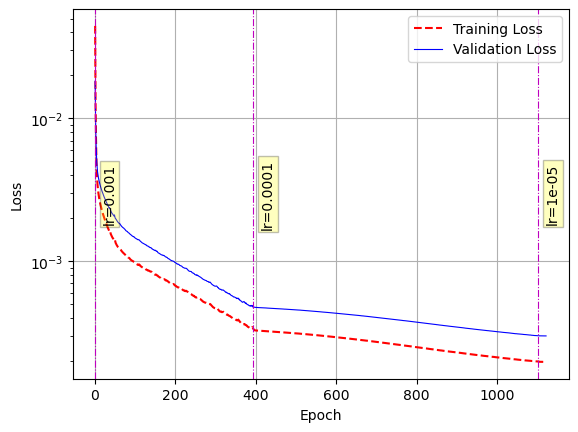

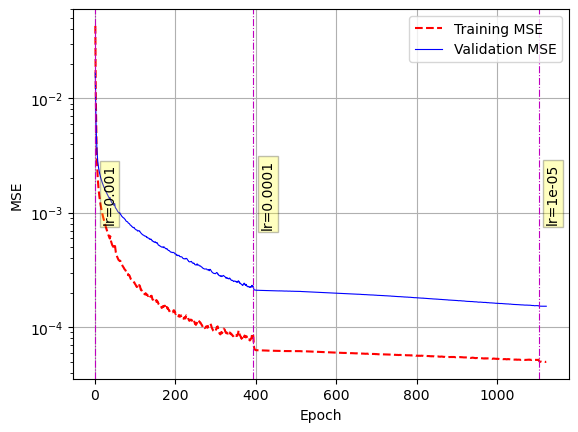

<Figure size 640x480 with 0 Axes>

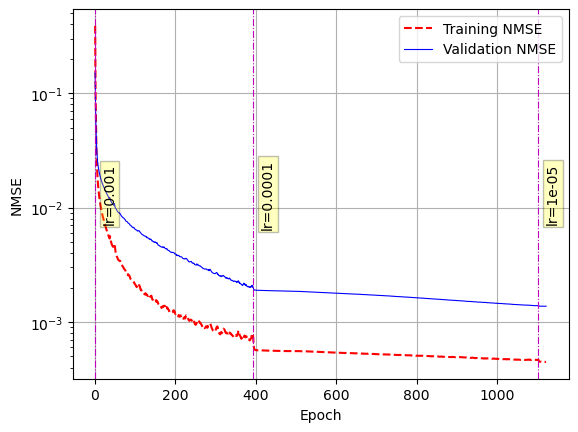

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 52


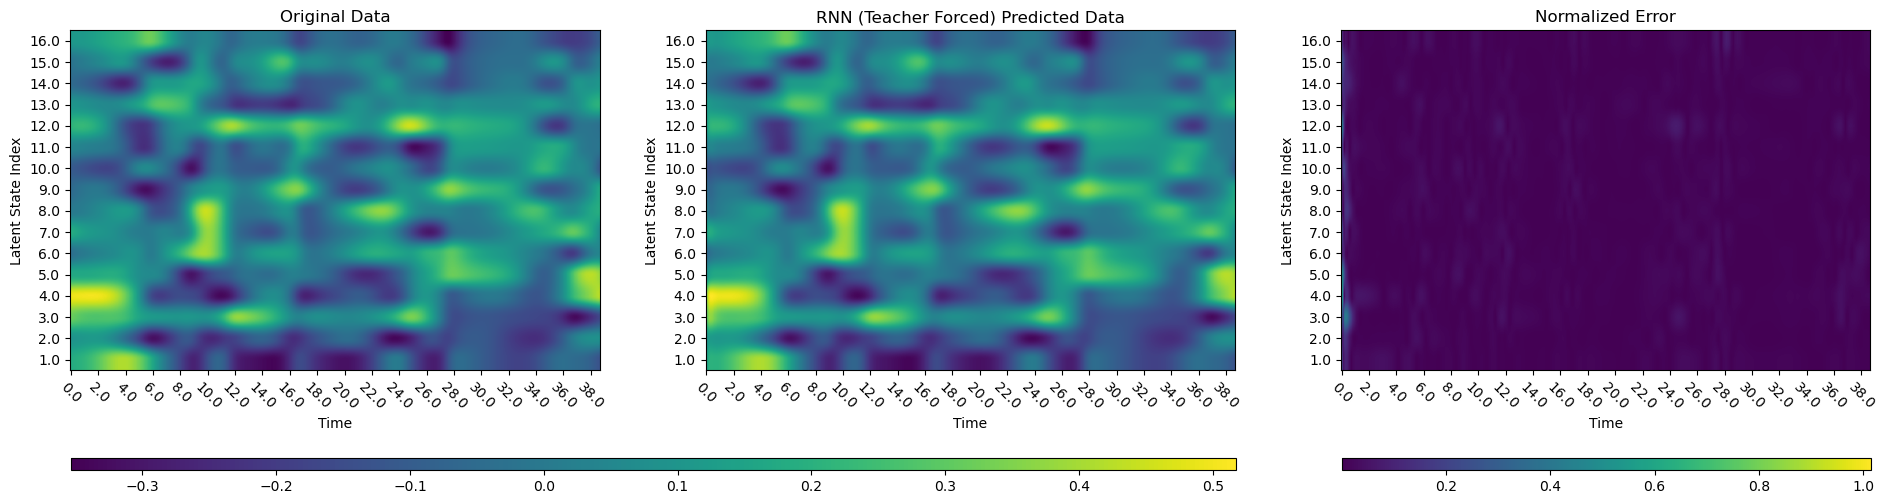

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


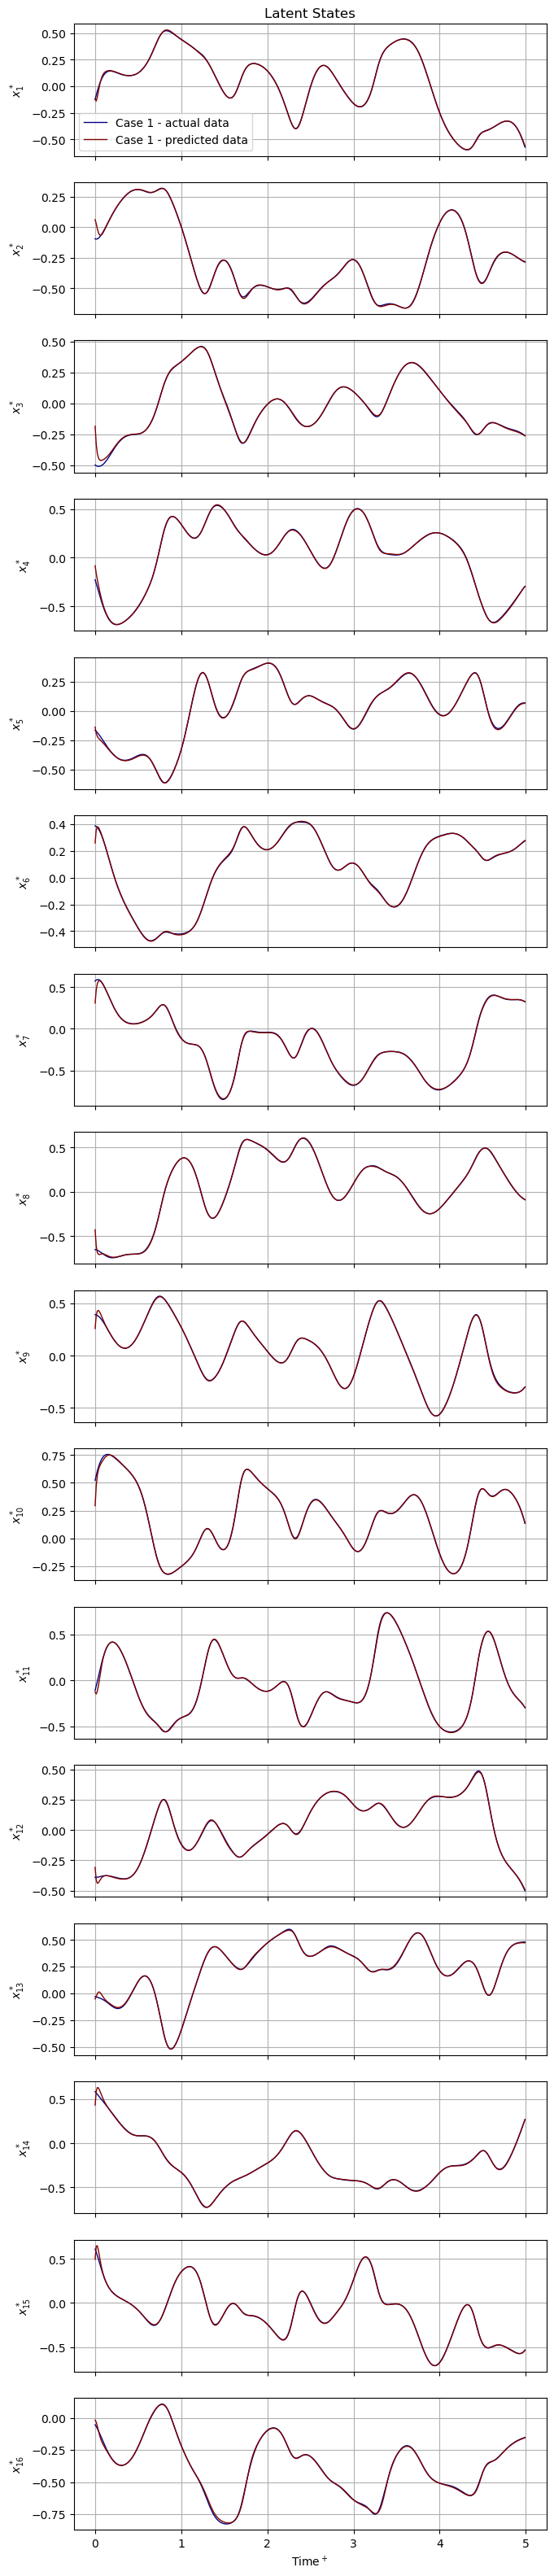


4.991497332033017


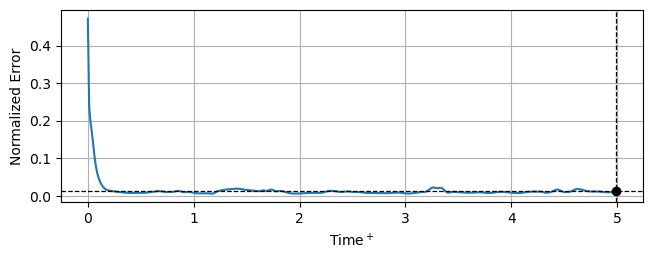

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-RNN.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[-0.01334152, -0.00261581,  0.02099581,  0.03006471,  0.0282602 ,
         0.0071317 ,  0.01005646,  0.07305361,  0.03375387,  0.02128131,
        -0.01137792, -0.0153523 ,  0.02832958,  0.00729525,  0.06112615,
         0.03638883],
       [ 0.57221735,  0.5165402 ,  0.56873006,  0.5798129 ,  0.5267395 ,
         0.5602617 ,  0.5400706 ,  0.5276647 ,  0.55953586,  0.4929259 ,
         0.45475405,  0.5388398 ,  0.49729973,  0.5216943 ,  0.44654998,
         0.49534416]], dtype=float32)

# Autoregressive Mode

In [43]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [44]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [45]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [46]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 850, 16)


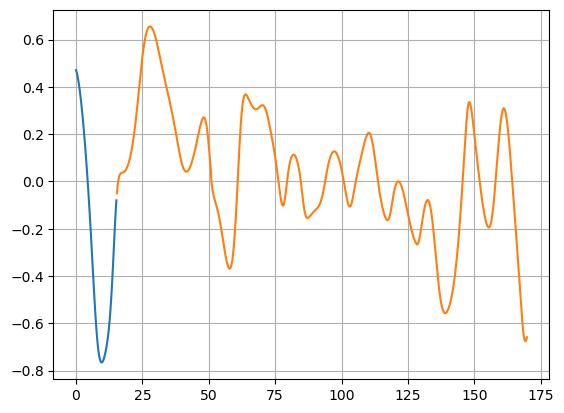

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [49]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [50]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 773, 16)


In [51]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.7888117545440779


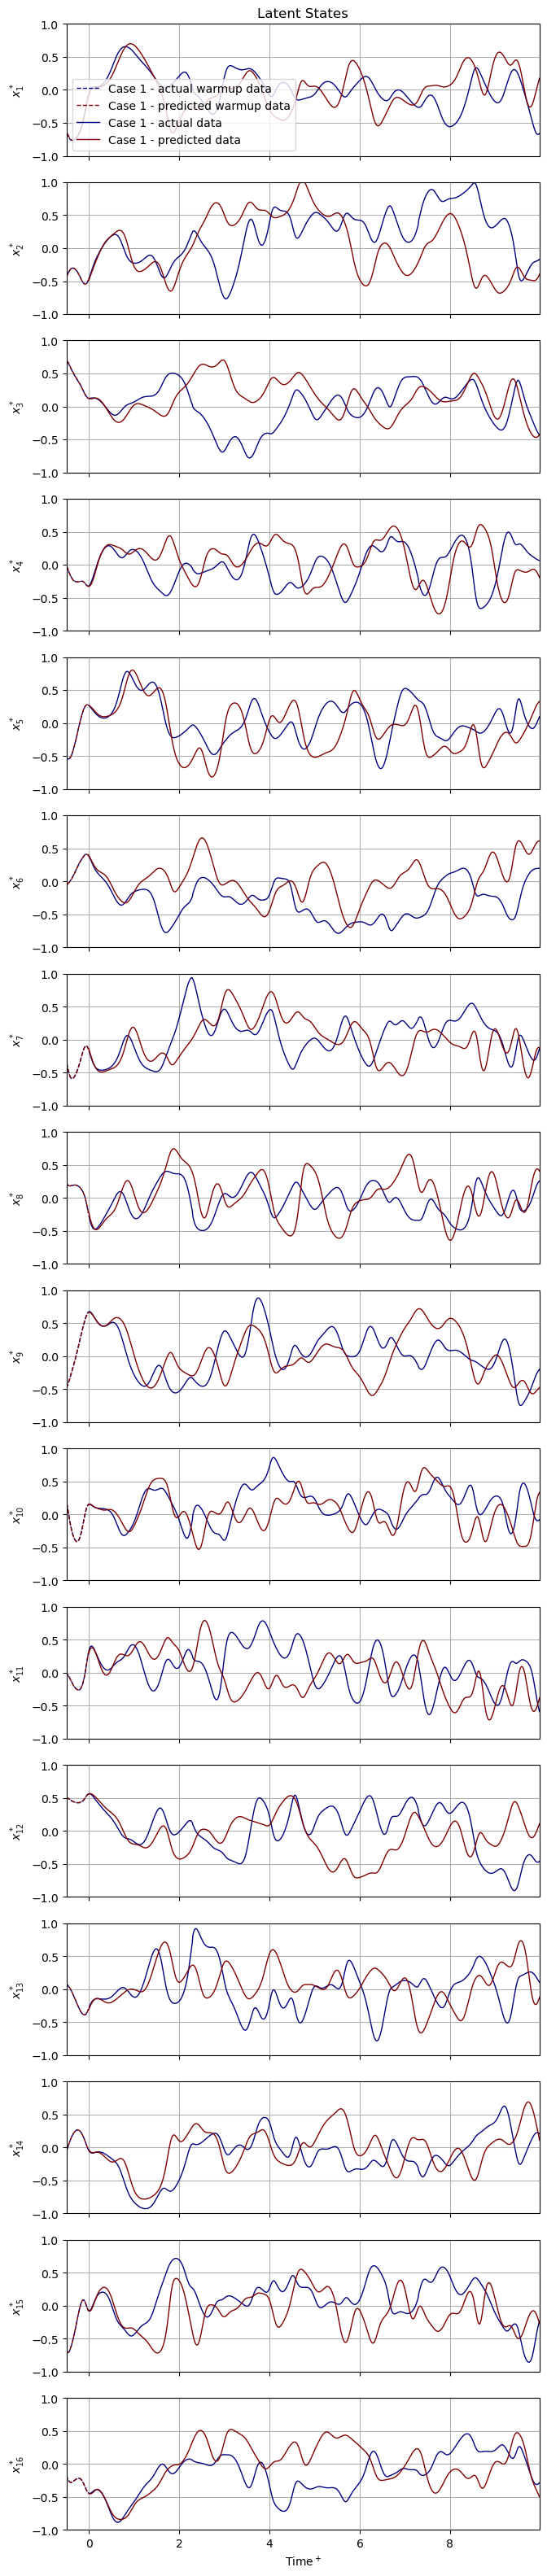

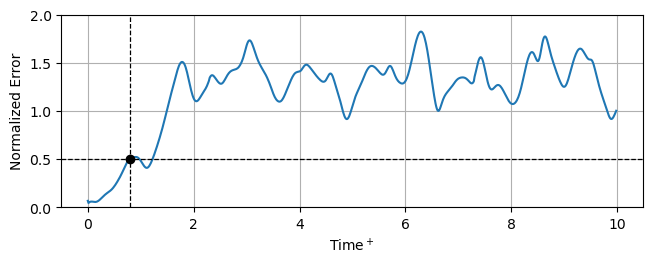

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [54]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_lstm/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.3357509, 1.3535331, 1.4036086, 1.384743 , 1.8116956, 1.4146825,
        1.4153534, 1.5676275, 1.547417 , 1.5256288, 1.4530585, 1.4521224,
        1.610926 , 1.4035103, 1.6848222, 1.0918413], dtype=float32)>]